In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import nltk
from nltk.corpus import  stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor

In [3]:
drug_df = pd.read_csv('dataset/train.csv')
drug_df

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,8.022969
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,7.858458
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,6.341969
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,6.590176
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,6.144782
...,...,...,...,...,...,...,...,...
32160,183202,Cymbalta,Anxiety,"""I have been taking Cymbalta for 15 months now...",9,10-Jun-13,89,6.963020
32161,109111,Nexplanon,Birth Control,"""I have had the Nexplanon since Dec. 27, 2016 ...",6,6-Apr-17,0,0.899076
32162,121154,Venlafaxine,Panic Disorde,"""Had panic attacks and social anxiety starting...",9,10-Nov-16,25,6.241812
32163,45410,Fluoxetine,Obsessive Compulsive Disorde,"""I have been off Prozac for about 4 weeks now....",8,21-Jan-15,22,7.940428


<AxesSubplot:>

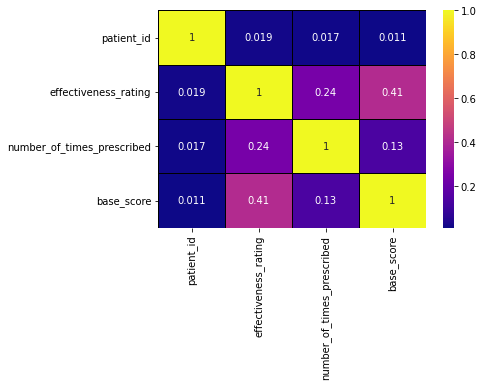

In [4]:
corr_df = drug_df.corr()
sns.heatmap(data=corr_df, annot = True, cmap ='plasma',  
            linecolor ='black', linewidths = 1)

In [5]:
target_y = drug_df.base_score.to_numpy()
drug_df.drop('base_score', axis=1, inplace=True)
drug_df

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
...,...,...,...,...,...,...,...
32160,183202,Cymbalta,Anxiety,"""I have been taking Cymbalta for 15 months now...",9,10-Jun-13,89
32161,109111,Nexplanon,Birth Control,"""I have had the Nexplanon since Dec. 27, 2016 ...",6,6-Apr-17,0
32162,121154,Venlafaxine,Panic Disorde,"""Had panic attacks and social anxiety starting...",9,10-Nov-16,25
32163,45410,Fluoxetine,Obsessive Compulsive Disorde,"""I have been off Prozac for about 4 weeks now....",8,21-Jan-15,22


In [6]:
drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32165 entries, 0 to 32164
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   patient_id                  32165 non-null  int64 
 1   name_of_drug                32165 non-null  object
 2   use_case_for_drug           32165 non-null  object
 3   review_by_patient           32165 non-null  object
 4   effectiveness_rating        32165 non-null  int64 
 5   drug_approved_by_UIC        32165 non-null  object
 6   number_of_times_prescribed  32165 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.7+ MB


In [7]:
drug_df['review_by_patient'] = drug_df['review_by_patient'].str.replace('\n', ' ')
drug_df['review_by_patient'] = drug_df['review_by_patient'].str.replace('\"', '')
drug_df['review_by_patient'][:5]

0    It has no side effect, I take it in combinatio...
1    My son is halfway through his fourth week of I...
2    I used to take another oral contraceptive, whi...
3    Suboxone has completely turned my life around....
4    2nd day on 5mg started to work with rock hard ...
Name: review_by_patient, dtype: object

In [8]:
def punctuation_to_features(df, column):
    df[column] = df[column].str.replace('!',' exclamation ')
    df[column] = df[column].str.replace('?',' question ')
    df[column] = df[column].str.replace('\'',' quotation ')
    df[column] = df[column].str.replace('\"',' quotation ')
    df[column] = df[column].str.replace('/', 'slash')
    
    return df[column]

In [9]:
drug_df['review_by_patient'] = punctuation_to_features(drug_df, 'review_by_patient')
drug_df['review_by_patient'].head()

/var/folders/s4/__1__jcd1ml4mz06wk6jnwwr0000gn/T/ipykernel_79038/1063184123.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column] = df[column].str.replace('?',' question ')


0    It has no side effect, I take it in combinatio...
1    My son is halfway through his fourth week of I...
2    I used to take another oral contraceptive, whi...
3    Suboxone has completely turned my life around....
4    2nd day on 5mg started to work with rock hard ...
Name: review_by_patient, dtype: object

In [10]:
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]

In [11]:
drug_df['review_by_patient_tokenized'] = drug_df.apply(lambda x : tokenize(x['review_by_patient']), axis=1)
drug_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,review_by_patient_tokenized
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,20-May-12,27,"[It, has, no, side, effect, I, take, it, in, c..."
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,27-Apr-10,192,"[My, son, is, halfway, through, his, fourth, w..."
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,14-Dec-09,17,"[I, used, to, take, another, oral, contracepti..."
3,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,27-Nov-16,37,"[Suboxone, has, completely, turned, my, life, ..."
4,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,28-Nov-15,43,"[day, on, started, to, work, with, rock, hard,..."


In [12]:
def remove_stopwords(tokenized_column):
    stops = set(stopwords.words('english'))
    return [word for word in tokenized_column if not word in stops]

In [13]:
drug_df['review_by_patient_tokenized'] = drug_df.apply(lambda x: remove_stopwords(x['review_by_patient_tokenized']), axis=1)
drug_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,review_by_patient_tokenized
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,20-May-12,27,"[It, side, effect, I, take, combination, Bysto..."
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,27-Apr-10,192,"[My, son, halfway, fourth, week, Intuniv, We, ..."
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,14-Dec-09,17,"[I, used, take, another, oral, contraceptive, ..."
3,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,27-Nov-16,37,"[Suboxone, completely, turned, life, around, I..."
4,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,28-Nov-15,43,"[day, started, work, rock, hard, erections, ho..."


In [14]:
def apply_stemming(tokenized_column):
    stemmer = PorterStemmer()
    return [stemmer.stem(word).lower() for word in tokenized_column]

In [15]:
drug_df['review_by_patient_tokenized'] = drug_df.apply(lambda x  : apply_stemming(x['review_by_patient_tokenized']),axis=1)
drug_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,review_by_patient_tokenized
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,20-May-12,27,"[it, side, effect, i, take, combin, bystol, mg..."
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,27-Apr-10,192,"[my, son, halfway, fourth, week, intuniv, we, ..."
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,14-Dec-09,17,"[i, use, take, anoth, oral, contracept, pill, ..."
3,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,27-Nov-16,37,"[suboxon, complet, turn, life, around, i, feel..."
4,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,28-Nov-15,43,"[day, start, work, rock, hard, erect, howev, e..."


In [16]:
def rejoin_words(tokenized_columns):
    return (' '.join(tokenized_columns))

In [17]:
drug_df['review_by_patient_all_text'] = drug_df.apply(lambda x: rejoin_words(x['review_by_patient_tokenized']), axis=1)
drug_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,review_by_patient_tokenized,review_by_patient_all_text
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,20-May-12,27,"[it, side, effect, i, take, combin, bystol, mg...",it side effect i take combin bystol mg fish oil
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,27-Apr-10,192,"[my, son, halfway, fourth, week, intuniv, we, ...",my son halfway fourth week intuniv we becam co...
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,14-Dec-09,17,"[i, use, take, anoth, oral, contracept, pill, ...",i use take anoth oral contracept pill cycl lig...
3,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,27-Nov-16,37,"[suboxon, complet, turn, life, around, i, feel...",suboxon complet turn life around i feel health...
4,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,28-Nov-15,43,"[day, start, work, rock, hard, erect, howev, e...",day start work rock hard erect howev experianc...


In [19]:
from sklearn.model_selection import train_test_split
X = drug_df['review_by_patient_all_text']

X_train, X_test, y_train, y_test = train_test_split(X, target_y, test_size=0.3, random_state=1)

In [20]:
pipeline = Pipeline(
    [
        ('tfidf',TfidfVectorizer()),
        ('model', XGBRegressor())
    ]
)

y_hat = pipeline.fit(X_train, y_train).predict(X_test)


from sklearn import metrics
print(y_hat.shape)
print(metrics.r2_score(y_true=y_test,y_pred=y_hat))

(9650,)
0.043019833586283696


    As we checked the reviews column doesnt have much impact on base score(target y). SO we can use need to use other columns to predict the base score. So we can drop the drop new generated column.

In [21]:
drug_df.drop(['review_by_patient_all_text', 'review_by_patient_tokenized'], axis=1, inplace=True)
drug_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,20-May-12,27
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,14-Dec-09,17
3,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,27-Nov-16,37
4,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,28-Nov-15,43


In [22]:
drug_df['use_case_for_drug'] = drug_df['use_case_for_drug'].str.replace('\n', ' ')
drug_df['use_case_for_drug'] = drug_df['use_case_for_drug'].str.replace('\"', '')
drug_df['use_case_for_drug'][:5]

0    Left Ventricular Dysfunction
1                            ADHD
2                   Birth Control
3               Opiate Dependence
4    Benign Prostatic Hyperplasia
Name: use_case_for_drug, dtype: object

In [23]:
drug_df['use_case_for_drug'] = punctuation_to_features(drug_df, 'use_case_for_drug')
drug_df['use_case_for_drug'].head()

/var/folders/s4/__1__jcd1ml4mz06wk6jnwwr0000gn/T/ipykernel_79038/1063184123.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column] = df[column].str.replace('?',' question ')


0    Left Ventricular Dysfunction
1                            ADHD
2                   Birth Control
3               Opiate Dependence
4    Benign Prostatic Hyperplasia
Name: use_case_for_drug, dtype: object

In [24]:
drug_df['use_case_for_drug_tokenized'] = drug_df.apply(lambda x : tokenize(x['use_case_for_drug']), axis=1)
drug_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug_tokenized
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,20-May-12,27,"[Left, Ventricular, Dysfunction]"
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,27-Apr-10,192,[ADHD]
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,14-Dec-09,17,"[Birth, Control]"
3,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,27-Nov-16,37,"[Opiate, Dependence]"
4,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,28-Nov-15,43,"[Benign, Prostatic, Hyperplasia]"


In [25]:
drug_df['use_case_for_drug_tokenized'] = drug_df.apply(lambda x: remove_stopwords(x['use_case_for_drug_tokenized']), axis=1)
drug_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug_tokenized
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,20-May-12,27,"[Left, Ventricular, Dysfunction]"
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,27-Apr-10,192,[ADHD]
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,14-Dec-09,17,"[Birth, Control]"
3,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,27-Nov-16,37,"[Opiate, Dependence]"
4,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,28-Nov-15,43,"[Benign, Prostatic, Hyperplasia]"


In [26]:
drug_df['use_case_for_drug_tokenized'] = drug_df.apply(lambda x  : apply_stemming(x['use_case_for_drug_tokenized']),axis=1)
drug_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug_tokenized
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,20-May-12,27,"[left, ventricular, dysfunct]"
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,27-Apr-10,192,[adhd]
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,14-Dec-09,17,"[birth, control]"
3,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,27-Nov-16,37,"[opiat, depend]"
4,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,28-Nov-15,43,"[benign, prostat, hyperplasia]"


In [27]:
drug_df['use_case_for_drug_text'] = drug_df.apply(lambda x: rejoin_words(x['use_case_for_drug_tokenized']), axis=1)
drug_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug_tokenized,use_case_for_drug_text
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,20-May-12,27,"[left, ventricular, dysfunct]",left ventricular dysfunct
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,27-Apr-10,192,[adhd],adhd
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,14-Dec-09,17,"[birth, control]",birth control
3,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,27-Nov-16,37,"[opiat, depend]",opiat depend
4,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,28-Nov-15,43,"[benign, prostat, hyperplasia]",benign prostat hyperplasia


In [28]:
vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit(drug_df['use_case_for_drug_text'])
X_bow = bow_transformer.transform(drug_df['use_case_for_drug_text'])
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(X_bow)

# Transform entire BoW into tf-idf corpus
X_tfidf = tfidf_transformer.transform(X_bow)
print(X_tfidf.shape)


(32165, 719)


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, target_y, test_size=0.3, random_state=1)

xgb_model = XGBRegressor()

y_hat = xgb_model.fit(X_train, y_train).predict(X_test)


from sklearn import metrics
print(y_hat.shape)
print(metrics.r2_score(y_true=y_test,y_pred=y_hat))

(9650,)
0.00529675150764819


    As we checked the use_case_of_drugs column doesnt have much impact on base score(target y). SO we can use need to use other columns to predict the base score. So we can drop the drop new generated column.

In [30]:
drug_df.drop([ 'use_case_for_drug_tokenized','use_case_for_drug_text'], axis=1, inplace=True)
drug_df.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,20-May-12,27
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,14-Dec-09,17
3,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,27-Nov-16,37
4,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,28-Nov-15,43


In [31]:
from sklearn.model_selection import train_test_split
X = drug_df[[ 'effectiveness_rating', 'number_of_times_prescribed']]
from sklearn.preprocessing import  MinMaxScaler
sc= MinMaxScaler()
X = sc.fit_transform(X)

print(X.shape)
print(target_y.shape)

(32165, 2)
(32165,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, target_y, test_size=0.3, random_state=1)

y_hat = xgb_model.fit(X_train, y_train).predict(X_test)


from sklearn import metrics

print(y_hat)
print(metrics.r2_score(y_true=y_test,y_pred=y_hat))

[7.202316  2.7601876 8.228925  ... 6.5784574 7.245444  8.594115 ]
0.9955622462196448


In [33]:

drug_df_test = pd.read_csv('dataset/test.csv')
X_test = drug_df_test[['effectiveness_rating','number_of_times_prescribed']]
X_test = sc.transform(X_test)
X_test

array([[1.        , 0.02853437],
       [0.88888889, 0.04539559],
       [0.33333333, 0.01686122],
       ...,
       [1.        , 0.05577173],
       [0.77777778, 0.00907912],
       [0.88888889, 0.05966278]])

In [34]:
y_hat = xgb_model.fit(X_train, y_train).predict(X_test)

y_hat


array([8.746462 , 8.795709 , 5.852787 , ..., 6.801085 , 5.2264395,
       8.195022 ], dtype=float32)

In [35]:
output = pd.DataFrame({'patient_id': drug_df_test.patient_id,
                       'base_score': y_hat})
output.to_csv('submission.csv', index=False)